# NIRの波長からTSMの濃度を求める

### パラメータの説明

|Rrs(L)|衛星から観測した反射率
|Fre|フレネルの式、入射光に対する反射光の強さを表す
|bb_to_b|backscatteringのscatteringに対する割合|
|

In [2]:
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
from bhmie import bhmie
import miepython

### パラメータ

In [6]:
#-----------------------------#
#     Set Parameters          #
#-----------------------------#
aw = [2.38,2.36 ] #/m Raymond C. Smith and Karen S. Baker 1981
bw = [0.0006,0.0004]#/m
nw = 1.333 #dimensionless
def n_prime(Lambda,coef1=0.010658,coef2=-0.007186):
    return 0.010658*np.exp(-0.007186*Lambda)
m = nw/1.148 #quartz
print(m)
dmin = 0.01*1e-6 #m
dmax = 100*1e-6  #m
pho = 2.65*1e6 #density of Quartz (g/m3)

1.161149825783972


### コード

In [11]:
def approximate_qbb_polynomial(m,order=40):
    def qbb(m,x):
        def scattering_for_eachAngle(theta):
            cos = np.cos(np.radians(theta))
            sin = np.sin(np.radians(theta))
            S1,S2 = miepython.mie_S1_S2(m,x,cos,norm="wiscombe")
            i1 = abs(S1) ** 2
            i2 = abs(S2) ** 2
            I  = i1+i2
            return I*sin
        integrated,err = integrate.quad(scattering_for_eachAngle,90,180)

        return integrated/(x**2)
    
    x=np.logspace(-2,4,1000)
    qbb_cal = np.array([qbb(m,x) for x in x])

    logx = np.log10(x)
    reg = np.polyfit(logx,qbb_cal,order)

    print("Regression finish.")
    
    return reg

### 便宜的に最初だけここにコードを置く

In [17]:
def PSD(D,j,K=1):
    """
    particle size distribution(PSD) N(D) = K*D^-j
    D: diameter of the particle
    j: parameter1
    K(optional): parameter2
    """
    return K * (D*1e6) ** (-j)
# def Qbb(D,Lambda,m):

#     x = 2 * np.pi * (D *1e-6)/ Lambda
#     s1,s2,qext,qsca,qback,gsca = bhmie(x,m,100)

#     return qback
# def Cbb(Lambda,m,j,dmin,dmax):
#     def numerator(D):
#         Q_bb = Qbb(D,Lambda,m)
#         ND = PSD(D,j)
#         return Q_bb * np.pi * D**2 * ND /4
    
#     def denominator(D):
#         ND = PSD(D,j)
#         return ND
#     print("I came")
#     integrated_numerator,err_numerator = integrate.quad(numerator,dmin,dmax)
#     print("You must come with me")
#     intergrated_denominator,err_denominator = integrate.quad(denominator,dmin,dmax)
#     print(f"Cbb = {integrated_numerator/intergrated_denominator}")
#     return integrated_numerator/intergrated_denominator
def Cbb(Lambda,reg,m,j,dmin,dmax):
    def numerator(D):
        x = 2 * np.pi * (D)/ (Lambda*1e-9)
        #qext, qsca, qback, g = miepython.mie(m,x)
        #s1,s2,qext,qsca,,gsca = bhmie(x,m,45)
        qbb = np.polyval(reg,np.log10(x))
        ND = PSD(D,j)
        return qbb * np.pi * D**2 * ND /4
    
    def denominator(D):
        ND = PSD(D,j)
        return ND
    integrated_numerator,err_numerator = integrate.quad(numerator,dmin,dmax)
    #nd = 100
    #Drange = np.linspace(dmin,dmax,nd)
    #Dseries = [numerator(D) for D in Drange]
    #integrated_numerator =sum(Dseries) *(dmax-dmin)/nd
    #print(f"numerator={integrated_numerator}")
    integrated_denominator,err_denominator = integrate.quad(denominator,dmin,dmax)
    #integrated_denominator = (dmax**(1-j) - dmin**(1-j))/(1-j)
    #print(f"Cbb = {integrated_numerator/integrated_denominator}")
    return integrated_numerator/integrated_denominator
def G(j,dmin,dmax):
    def numerator(D):
        ND = PSD(D,j)
        return ND * (D **2)
    
    def denominator(D):
        ND = PSD(D,j)
        return ND
    
    integrated_numerator,err_numerator = integrate.quad(numerator,dmin,dmax)
    integrated_denominator,err_denominator = integrate.quad(denominator,dmin,dmax)
    #print(f"分子={integrated_numerator},分母={integrated_denominator}")
    # if j - 3.0 < 1e-3:
    #     integrated_numerator =  (dmax**(1-j+2) - dmin**(1-j+2))/(1-j+2)
    # else:
    #     integrated_numerator = dmax-dmin
    #integrated_denominator = (dmax**(1-j) - dmin**(1-j))/(1-j)
    return np.pi*integrated_numerator/integrated_denominator/4
def bbp_SIOP(Lambda,reg,j,m,pho,dmin,dmax):
    m = m - n_prime(Lambda)*1j
    #print(f"WaveLength = {Lambda},refractiveIndex={m}")
    #print(G(j,dmin,dmax))
    Qbb_ave = Cbb(Lambda,reg,m,j,dmin,dmax)/G(j,dmin,dmax)
    #print(f"Qbb_ave={Qbb_ave}")
    def numerator(D):
        ND = PSD(D,j)
        return ND * (D **2)
    
    def denominator(D):
        ND = PSD(D,j)
        return ND * (D **3)
    
    integrated_numerator,err_numerator = integrate.quad(numerator,dmin,dmax)
    intergrated_denominator,err_denominator = integrate.quad(denominator,dmin,dmax) 
    #print(f"分子={integrated_numerator},分母={intergrated_denominator}")
    return 3 * Qbb_ave * integrated_numerator / (2 * pho * intergrated_denominator)  


In [10]:
Lambda=500
j=-4
reg = approximate_qbb_polynomial(m,order=40)
bbp_SIOP(Lambda,reg,j,m,pho,dmin,dmax)

/tmp/ipykernel_2356873/1569894960.py:11: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integrated,err = integrate.quad(scattering_for_eachAngle,90,180)


SystemError: CPUDispatcher(<function _mie_S1_S2 at 0x7f6e94ae8cc0>) returned a result with an exception set

#### 後方散乱のSIOPsの確認

In [18]:
wavelength = np.linspace(400,800,100)
j = 4.0
fig,ax = plt.subplots()
#for m in (1.12,1.15,1.18,1.22):
m = 1.12
reg = approximate_qbb_polynomial(m,order=40)
siop = np.zeros(len(wavelength))
for i,Lambda in enumerate(wavelength):
    siop[i] = bbp_SIOP(Lambda,reg,j,m,pho,dmin,dmax)
ax.plot(wavelength,siop,label=m)
#ax.set_ylim(0,1)
ax.legend()
plt.show()

/tmp/ipykernel_2356873/103396568.py:11: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integrated,err = integrate.quad(scattering_for_eachAngle,90,180)


### Check Junge function(PSD)
半径の単位をμmにすしてJunge functionを適用すると、Sławomir B. Woz´ niak and Dariusz Stramski(2004)のFig2(d)に一致。このことから、Junge functionにおいては単位をμmにしていると考えられる。

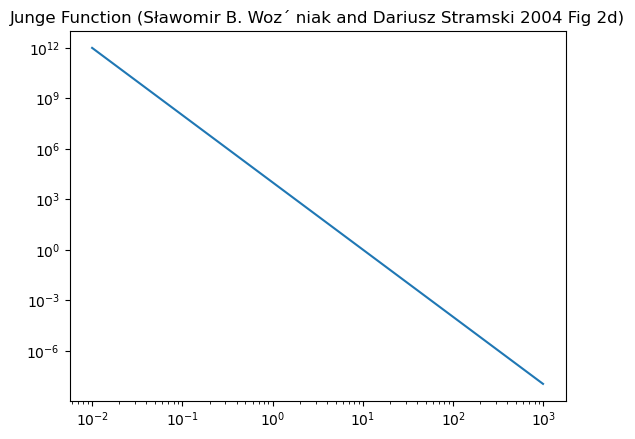

In [8]:
j = 4
def PSD(D,j,K=1):
    """
    particle size distribution(PSD) N(D) = K*D^-j
    D: diameter of the particle
    j: parameter1
    K(optional): parameter2
    """
    return K * (D) ** (-j)
diameter = np.arange(0.01,1000,10)
sizeDistribution = [PSD(D,j,K=1e4) for D in diameter]

fig,ax = plt.subplots()
ax.plot(diameter,sizeDistribution)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title("Junge Function (Sławomir B. Woz´ niak and Dariusz Stramski 2004 Fig 2d)")
plt.show()
fig.savefig("../png/JungeFunction.png")

### 複素屈折率の虚部の値の確認
λの単位をnmにしたところSławomir B. Woz´ niak and Dariusz Stramskiにおいて複素屈折率のオーダーが1e-4になった。これでちょうどよいと考えられる。Fig2cと一致している。

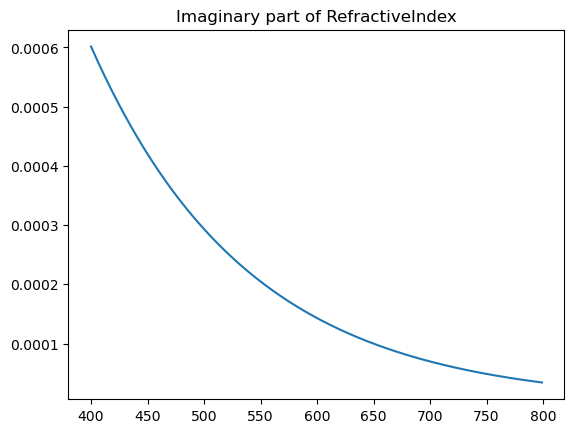

In [15]:

def n_prime(Lambda):
    """
    particle size distribution(PSD) N(D) = K*D^-j
    D: diameter of the particle
    j: parameter1
    K(optional): parameter2
    """
    return 0.010658*np.exp(-0.007186*Lambda)
Lambda = np.arange(400,800,1)
complexRefractiveIndex = [n_prime(l) for l in Lambda]

fig,ax = plt.subplots()
ax.plot(Lambda,complexRefractiveIndex)
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_title("Imaginary part of RefractiveIndex")
plt.show()
fig.savefig("../png/Refractive_index.png")

In [ ]:
### 
def derive_Tbb(bb_Ratio,sbb,cTSM):
    """
    
    """
    return bb_Ratio*sbb*cTSM

def derive_Rrs_0minus(aw,bw,bbTSM):
    return (bw+bbTSM)/(aw+bw+bbTSM)


θv is the viewing zenith angle;
θs is the sun zenith angle; r(θv) and r(θs) are reflectance
over the water-atmosphere surface, which
can be calculated by Fresnel formula;

### input Rrs

In [30]:
#just an example
Rrs_MSupper = [0.00276869 ,0.00507279, 0.00603331, 0.00601718, 0.00283981, 0.0027035 ]
MO = [0.00120341, 0.00207419, 0.00292378, 0.00305579, 0.00200239, 0.00197148]
MS_lower = [0.03171935 ,0.04893871, 0.06325484 ,0.06439677 ,0.04043226 ,0.03886452]
wavelength = [490,560,665,705,740,783]

In [ ]:
def Fresnel(theta):
    return

In [ ]:
#def rrs(Rrs,Lambda,theta_s,theta_v,nw):
#    rrs_Lambda = Rrs[Lambda] / ((1-Fresnel(theta_v))*(1-Fresnel(theta_s))/(nw**2))
#    return rrs_Lambda

In [28]:
#def bbp_SIOP(Lambda,j,m,pho,dmin,dmax):
def deriveConcentration(Rrs,Lambda1,Lambda2,j,m,pho,theta_s,theta_v,
                        dmin=dmin,dmax=dmax,aw=aw,bw=bw,):
    """
    Return:
    Concentration(mg/L) 1e6をかけることでg/m3からmg/Lに変更されているはず
    """
    #first, derive SIOPs at each wavelength.
    bbp_SIOP_lambda1 = bbp_SIOP(Lambda1,j,m,pho,dmin,dmax) #m2/g→
    bbp_SIOP_lambda2 = bbp_SIOP(Lambda2,j,m,pho,dmin,dmax)
    print(bbp_SIOP_lambda1)
    #second, convert Rrs to rrs (subsurface water)
    #水面で屈折するからRrsから水面直下の反射率に変える必要がある
    rrs_lambda1 = Rrs[-2]#rrs(Rrs,Lambda1,theta_s,theta_v)
    rrs_lambda2 = Rrs[-1]#rrs(Rrs,Lambda2,theta_s,theta_v)

    #third, derive Concentration
    concentration_numerator = rrs_lambda1 * aw[0] * bbp_SIOP_lambda2 - (rrs_lambda2 * aw[1] * bbp_SIOP_lambda1)
    concentration_denominator = bbp_SIOP_lambda1 * bbp_SIOP_lambda2 * (rrs_lambda2-rrs_lambda1)
    return 1e6*concentration_numerator/concentration_denominator #g/m3

WaveLength = 740,refractiveIndex=(1.161149825783972-5.227018138410898e-05j)


/tmp/ipykernel_979493/3384130097.py:40: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integrated_numerator,err_numerator = integrate.quad(numerator,dmin,dmax)


Cbb = 13.0963315461102
Qbb_ave=16.6747672154701
WaveLength = 783,refractiveIndex=(1.161149825783972-3.837583876959838e-05j)
Cbb = 4.157312514546142
Qbb_ave=5.293254693342524
1.8875207440165532e-07
WaveLength = 740,refractiveIndex=(1.161149825783972-5.227018138410898e-05j)
Cbb = 0.03551669597899599
Qbb_ave=2.912935346659107
WaveLength = 783,refractiveIndex=(1.161149825783972-3.837583876959838e-05j)
Cbb = 0.04405281960205186
Qbb_ave=3.6130335832674927
5.625965084363222e-08
WaveLength = 740,refractiveIndex=(1.161149825783972-5.227018138410898e-05j)
Cbb = 0.0004021961069982789
Qbb_ave=0.5532171854403578
WaveLength = 783,refractiveIndex=(1.161149825783972-3.837583876959838e-05j)
Cbb = 0.000492460522333011
Qbb_ave=0.6773750898258263
6.654796501080499e-08
WaveLength = 740,refractiveIndex=(1.161149825783972-5.227018138410898e-05j)
Cbb = 8.454317290469525e-06
Qbb_ave=0.03077476355707991
WaveLength = 783,refractiveIndex=(1.161149825783972-3.837583876959838e-05j)
Cbb = 8.468590479069155e-06
Qbb_a

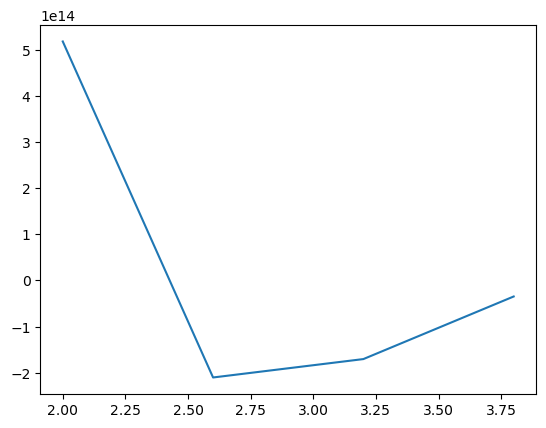

In [31]:
jseries = np.arange(2.0,4.0,0.6)
concentration = np.zeros(len(jseries))

fig,ax = plt.subplots()
for i,j in enumerate(jseries):
    concentration[i] = deriveConcentration(Rrs_MSupper,740,783,j,m,pho,0,0)

ax.plot(jseries,concentration)
plt.show()

In [ ]:

#Rrs1[lambda,t],Rrs2,Rrs3
#Q1[t],Q2,Q3
for t in range(10):
    C1 = deriveConcentration(Rrs,Lambda1,Lambda2,j1,m,pho,theta_s,theta_v,
                            dmin=dmin,dmax=dmax,aw=aw,bw=bw,)
    C2 = deriveConcentration(Rrs,Lambda1,Lambda2,j2,m,pho,theta_s,theta_v,
                            dmin=dmin,dmax=dmax,aw=aw,bw=bw,)

    #C3 = (C1 * Q1 + C2 * Q2)/Q3
    #j3 = 3 # 後で変える

    

